In [2]:
# Import the environments from gym  
import gym
import numpy as np
import torch
import random
from matplotlib import pyplot as plt

### REINFORCE on OpenAI GYM - CartPole

In [3]:
torch.seed = 1234
np.random.seed(torch.seed)
random.seed(torch.seed)

In [4]:
# List the environments offered by gym
gym.envs.registry.all()

ValuesView(├──CartPole: [ v0, v1 ]
├──MountainCar: [ v0 ]
├──MountainCarContinuous: [ v0 ]
├──Pendulum: [ v1 ]
├──Acrobot: [ v1 ]
├──LunarLander: [ v2 ]
├──LunarLanderContinuous: [ v2 ]
├──BipedalWalker: [ v3 ]
├──BipedalWalkerHardcore: [ v3 ]
├──CarRacing: [ v1 ]
├──Blackjack: [ v1 ]
├──FrozenLake: [ v1 ]
├──FrozenLake8x8: [ v1 ]
├──CliffWalking: [ v0 ]
├──Taxi: [ v3 ]
├──Reacher: [ v2 ]
├──Pusher: [ v2 ]
├──InvertedPendulum: [ v2 ]
├──InvertedDoublePendulum: [ v2 ]
├──HalfCheetah: [ v2, v3 ]
├──Hopper: [ v2, v3 ]
├──Swimmer: [ v2, v3 ]
├──Walker2d: [ v2, v3 ]
├──Ant: [ v2, v3 ]
├──Humanoid: [ v2, v3 ]
└──HumanoidStandup: [ v2 ]
)

In [5]:
# Create the CartPole Environment
env = gym.make('CartPole-v1')

In [6]:
state = env.reset()
print('Sample State:', state)
print('Action Set:', env.action_space)

Sample State: [ 0.04614099 -0.0406047   0.0151189   0.010544  ]
Action Set: Discrete(2)


#### Create the helper functions

In [7]:
# Computing the discounted rewards
def discountRewards(rewards, gamma=0.99):
    lenR = len(rewards)
    discReturn = torch.pow(gamma, torch.arange(lenR).float()) * rewards
    # Normalizes the rewards to be within 0 and 1 interval to improve numerical stability
    discReturn = discReturn / discReturn.max()
    return discReturn

In [8]:
# Define the loss function
# Function expects an array of action probabilities for the actions that were taken and the discounted rewards
def lossFun(preds, r):
    # Computes the log of the probabilities, multiplies byu the discounted rewards, sums them all, and flips the sign
    return -1 * torch.sum(r * torch.log(preds))

#### Create the Model

In [24]:
# Create the model
model = torch.nn.Sequential(
    torch.nn.Linear(4, 250),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(250, 2),
    torch.nn.Softmax(dim=0)
)

learningRate = 0.009
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)

#### Train the model

In [25]:
# REINFORCE training loop
maxEpisodes = 1000 # Number of episodes to train on
maxMoves = 250 # Max number of allowed moves per episode
gamma = 0.8
# A list to keep track of the episode length over training time
score = []
for episode in range(maxEspisodes):
    currentState = env.reset()
    done = False
    # A list of state, action, reward
    transitions = []
    # In each episode, the max number of allowed moves if the game hasnt already ended yet
    for t in range(maxMoves):
        # Calculate the action probabilites
        actionProb = model(torch.from_numpy(currentState).float())
        # Will choose actions 0 or 1 based on their respective probability (stochastically)
        action = np.random.choice(np.array([0, 1]), p=actionProb.detach().numpy())
        previousState = currentState
        # Perform the selected action in the environment
        currentState, reward, done, info = env.step(action)        
        # Store the transition. We do t+reward, as reward for cartpole if always one if the pole is upright. 
        # It will be game over if it doesnot receive a reward or done=True
        transitions.append((previousState, action, t+reward))
        # If the game is lost
        if done: 
            break

    # Store the length of the episode until now
    episodeLen = len(transitions)
    score.append(episodeLen)

    rewardBatch = torch.Tensor([r for (s, a, r) in transitions]).flip(dims=(0, ))
    discountedRewards = discountRewards(rewardBatch) # Compute the discounted version of rewards
    # Collects the states in the episode in a single tensor
    stateBatch = torch.Tensor([s for (s, a, r) in transitions])
    # Collects the actions in the episode in a single tensor
    actionBatch = torch.Tensor([a for (s, a, r) in transitions])

    # Recomputes the action probabilites for all the states in the episode
    predictedActionProbBatch = model(stateBatch)
    # Sunsets of the action probabilites associated with the actions that were actually taken
    choosenPredictedActionProbBatch = predictedActionProbBatch.gather(dim=1, index=actionBatch.long().view(-1,1)).squeeze()
    # Calculate the loss
    loss = lossFun(choosenPredictedActionProbBatch, discountedRewards)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print the progress
    if episode % np.round(maxEpisodes/10) == 0:               
        print('episode: {:d}, score: {:.2f}'.format(episode, score[episode]))





episode: 0, score: 15.00
episode: 100, score: 38.00
episode: 200, score: 88.00
episode: 300, score: 135.00
episode: 400, score: 249.00
episode: 500, score: 85.00
episode: 600, score: 102.00
episode: 700, score: 128.00
episode: 800, score: 250.00
episode: 900, score: 250.00


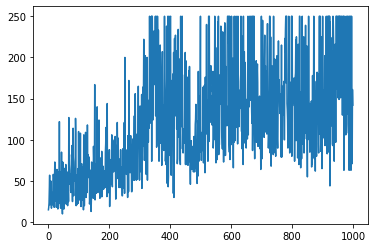

In [26]:
plt.plot(score)

#### Test the Model

In [27]:
# Test it
done = False
numMoves = 0
maxMoves = 500
totalReward = 0
while not done and maxMoves > 0:
    numMoves += 1
    maxMoves -= 1
    currentState = env.reset()
    # Uncomment, the following if you want to render it. Comment if you do not want to render it
    #env.render()
    # Calculate the action probabilites
    actionProb = model(torch.from_numpy(currentState).float())
    # Will choose actions 0 or 1 based on their respective probability (stochastically)
    action = np.random.choice(np.array([0, 1]), p=actionProb.detach().numpy())
    previousState = currentState
    # Perform the selected action in the environment
    currentState, reward, done, info = env.step(action)     
    totalReward += reward

print('Total Reward {} in {} moves.'.format(totalReward, numMoves))


Total Reward 500.0 in 500 moves.
